start!!
goal is found!


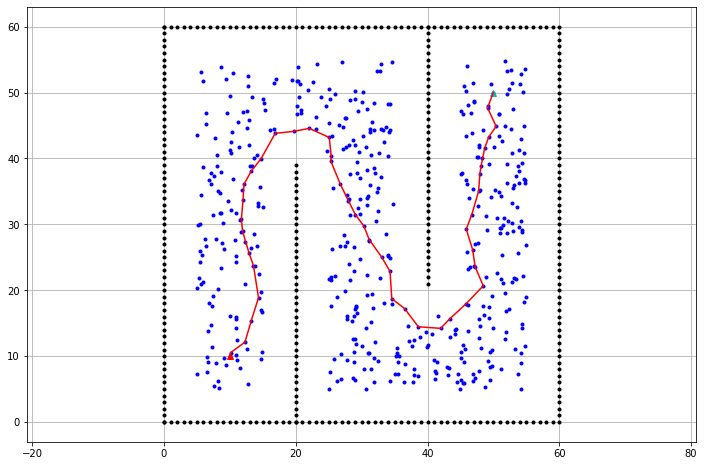

In [37]:
"""
Probabilistic Road Map (PRM) Planner
author: Atsushi Sakai (@Atsushi_twi)
"""
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# parameter
N_SAMPLE = 500  # number of sample_points
N_KNN = 10  # number of edge from one sampled point
MAX_EDGE_LEN = 30.0  # maximum edge length

# options
show_animation = True
show_road_map = False

class Node:
    """
    Node class for dijkstra search
    """
    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," + str(self.cost) + "," + str(self.parent_index)


def prm_planning(sx, sy, gx, gy, ox, oy, rr):
    """PRM planning between two points over an obstacle course while considering robot footprint
    
    Args:
        sx: starting point's x coordinate
        sy: starting point's y coordinate
        gx: ending point's x coordinate
        gy: ending point's y coordinate
        ox (1D list): list containing x coordinates of all obstacles
        oy (1D list): list containing y coordinates of all obstacles
        rr: robot's readius
    """
    # Road map construction phase
    # setup the obstacle kd-tree using the list of obstacle (x,y) coordinates
    obstacle_kd_tree = cKDTree(np.vstack((ox, oy)).T)

    # sample points
    sample_x, sample_y = sample_points(sx, sy, gx, gy, rr, ox, oy, obstacle_kd_tree)
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")

    # generate graph for road map
    road_map = generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree)

    # Query phase
    rx, ry = dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y)

    return rx, ry


def is_collision(sx, sy, gx, gy, rr, obstacle_kd_tree):
    """Checks if there is edge between (sx,sy) and (gx,gy) is collision free
    
    Args:
        sx: starting point's x coordinate
        sy: starting point's y coordinate
        gx: ending point's x coordinate
        gy: ending point's y coordinate
        rr: robot's readius
        obstacle_kd_tree (cKDTree): kd tree for (ox,oy)
        
    Returns:
        True if there is a collision, false otherwise
    """
    x = sx
    y = sy
    dx = gx - sx
    dy = gy - sy
    yaw = math.atan2(gy - sy, gx - sx)
    d = math.hypot(dx, dy)

    # case 1: if the distance is beyond a threshold, we assume there will be a collision
    if d >= MAX_EDGE_LEN:
        return True

    # case 2: step along the path to check if path is feasible
    # a feasible path is one where there is no collisions for all the intermediate positions 
    # from the start and end points
    D = rr
    n_step = round(d / D)
    for i in range(n_step):
        dist, _ = obstacle_kd_tree.query([x, y])
        if dist <= rr:
            return True
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # case 3: check if the goal node is too close to an obstacle
    dist, _ = obstacle_kd_tree.query([gx, gy])
    if dist <= rr:
        return True

    return False


def generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree):
    """ Road map generation
    
    Args:
        sample_x (1D list): x positions of sampled points
        sample_y (1D list): y positions of sampled points
        rr: robot radius
        obstacle_kd_tree (cKDTree): KDTree object of obstacles
        
    Returns:
        road_map (2D list): outer list denotes the index of a sample point, inner list contains 
                            all the KNN number of neighboring samples that is collision free from this sample 
                            point
    """
    road_map = []
    n_sample = len(sample_x)
    sample_kd_tree = cKDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(n_sample), sample_x, sample_y):
        # finds all samples from the kd-tree 
        dists, indexes = sample_kd_tree.query([ix, iy], k=n_sample)
        edge_id = []

        # add k edges that forms a collision free path from current node to the k nearest node
        for ii in range(1, len(indexes)):
            nx = sample_x[indexes[ii]]
            ny = sample_y[indexes[ii]]
            if not is_collision(ix, iy, nx, ny, rr, obstacle_kd_tree):
                edge_id.append(indexes[ii])
            if len(edge_id) >= N_KNN:
                break

        # appends a list of edges to road_map (of this sample)
        # note that there should be more query-friendly graph data structures for this
        road_map.append(edge_id)

    if show_road_map == True:
        plot_road_map(road_map, sample_x, sample_y)

    return road_map


def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """Find shortest distance path between two nodes on a road map
    
    Args:
        sx: start x position
        sy: start y position
        gx: goal x position
        gy: goal y position
        road_map (2D list): list of list of connected edges 
                            [[indices of node index 0's edges], [... of node 1's edges]]
        sample_x (1D list): x coordinate of samples
        sample_y (1D list): y coordinate of samples
        
    Returns: 
        Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """
    start_node = Node(sx, sy, 0.0, -1)
    goal_node = Node(gx, gy, 0.0, -1)

    open_set, closed_set = dict(), dict()
    open_set[len(road_map) - 2] = start_node

    path_found = True

    while True:
        if not open_set:
            print("Cannot find path")
            path_found = False
            break

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        current = open_set[c_id]

#         # show graph
#         if show_animation and len(closed_set.keys()) % 2 == 0:
#             # for stopping simulation with the esc key.
#             plt.gcf().canvas.mpl_connect(
#                 'key_release_event',
#                 lambda event: [exit(0) if event.key == 'escape' else None])
#             plt.plot(current.x, current.y, "xg")
#             plt.pause(0.001)

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    if path_found is False:
        return [], []

    # generate final course
    rx, ry = [goal_node.x], [goal_node.y]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        rx.append(n.x)
        ry.append(n.y)
        parent_index = n.parent_index

    return rx, ry


def plot_road_map(road_map, sample_x, sample_y):
    """Plots the road map edges
    
    Args:
        road_map (2D list): outer list denotes the index of the sample, inner list are the indices 
                            of the nodes connected to this node
        sample_x (1D list): list containing x coordinates of the samples
        sample_y (1D list): list containing y coordinates of the samples
    """
    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]

            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-k")


def sample_points(sx, sy, gx, gy, rr, ox, oy, obstacle_kd_tree):
    """Samples points on the world map, considering the obstacles and including the start and goal points
 
    Args:
        sx: x coordinate of starting point
        sy: y coordinate of starting point
        gx: x coordinate of goal point
        gy: y coordinate of goal point
        rr: robot size
        ox (1D list): list containing x coordinates of all obstacles
        oy (1D list): list containing y coordinates of all obstacles
        obstacle_kd_tree (cKDTree): kd tree for (ox,oy)
     
    Returns:
        1D list: x coordinates of all samples
        1D list: y coordinates of all samples
    """
    
    # maximum bounding area to create samples
    max_x = max(ox)
    max_y = max(oy)
    min_x = min(ox)
    min_y = min(oy)

    # sample only points that are at least robot size away from the obstacles
    sample_x, sample_y = [], []
    while len(sample_x) <= N_SAMPLE:
        tx = (random.random() * (max_x - min_x)) + min_x
        ty = (random.random() * (max_y - min_y)) + min_y

        dist, index = obstacle_kd_tree.query([tx, ty])

        if dist >= rr:
            sample_x.append(tx)
            sample_y.append(ty)

    # include the start and goal points
    sample_x.append(sx)
    sample_y.append(sy)
    sample_x.append(gx)
    sample_y.append(gy)

    return sample_x, sample_y


def main():
    print("start!!")

    # start and goal position
    sx = 10.0  # [m]
    sy = 10.0  # [m]
    gx = 50.0  # [m]
    gy = 50.0  # [m]
    robot_size = 5.0  # [m]

    # setup the obstacles
    ox = []
    oy = []
    for i in range(60):
        ox.append(i)
        oy.append(0.0)
    for i in range(60):
        ox.append(60.0)
        oy.append(i)
    for i in range(61):
        ox.append(i)
        oy.append(60.0)
    for i in range(61):
        ox.append(0.0)
        oy.append(i)
    for i in range(40):
        ox.append(20.0)
        oy.append(i)
    for i in range(40):
        ox.append(40.0)
        oy.append(60.0 - i)


    # start PRM planning
    rx, ry = prm_planning(sx, sy, gx, gy, ox, oy, robot_size)
    
    if show_animation:
        # plot the workspace
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "^r")
        plt.plot(gx, gy, "^c")
        plt.grid(True)
        plt.axis("equal")
        # plot the result
        plt.plot(rx, ry, "-r")
        plt.show()

if __name__ == '__main__':
    main()